### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [ ]:
pip install category_encoders

In [ ]:
pip install catboost

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier



import category_encoders as ce

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from catboost import Pool, cv
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Load datasets

In [ ]:
DATA_PATH = Path.cwd().parent / "content" / "drive" / "My Drive" / "ml_project" / "dataset"

In [ ]:
!ls '/content/drive/My Drive/ml_project/dataset'

features_df.csv     submission_15_2.csv    submission_5.csv
labels_df.csv	    submission_15.csv	   submission_6.csv
my_submission1.csv  submission_15_nom.csv  submission_7.csv
submission_10.csv   submission_16.csv	   submission_8.csv
submission_11.csv   submission_1.csv	   submission_9.csv
submission_12.csv   submission_2.csv	   SubmissionFormat.csv
submission_13.csv   submission_3.csv	   test_df.csv
submission_14.csv   submission_4.csv


In [ ]:
!pwd

/content


In [ ]:
#train data
features_df = pd.read_csv(
    DATA_PATH / "features_df.csv",
    index_col="id"
)

#label data
labels_df = pd.read_csv(
    DATA_PATH / "labels_df.csv", 
    index_col="id"
)

#test data
test_df = pd.read_csv(DATA_PATH / "test_df.csv",
                      index_col='id')

In [ ]:
joined_df = features_df.join(labels_df)

In [ ]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (59400, 39)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
print(features_df['latitude'].min(), features_df['latitude'].max())

-11.64944018 -2e-08


In [ ]:
# 'date_recorded': 356, 'funder': 1898, 'installer': 2146, 'wpt_name': 37400, 'subvillage': 19288, 'lga': 125, 'ward': 2092, 'scheme_name': 2697

In [ ]:
print("test_df.shape", test_df.shape)
test_df.head()

test_df.shape (14850, 39)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [ ]:
labels_df.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


## **Exploratory Data Analysis (EDA)**

In [ ]:
#in features_df
features_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

### **Categorical features**

In [ ]:
#find categorical columns
cat_cols = features_df.columns[features_df.dtypes == "object"].values
print(cat_cols)

['date_recorded' 'funder' 'installer' 'wpt_name' 'basin' 'subvillage'
 'region' 'lga' 'ward' 'public_meeting' 'recorded_by' 'scheme_management'
 'scheme_name' 'permit' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group']


In [ ]:
rmlist = ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']

In [ ]:
#above rmlist contains the categorical features with large number of categories. So I assume that label encoding would be a good option for those features.
# but when take a look at the high number of unique category count of each columns, seems like it will be not neccesary to use those features for the model. 
cat_cols_label = rmlist.copy()

In [ ]:
plot_cat_cols = [x for x in cat_cols if x not in rmlist]

In [ ]:
print(plot_cat_cols)

['basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [ ]:
for cat in cat_cols:
  print('col-name:',cat,len(features_df[cat].unique()))

col-name: date_recorded 356
col-name: funder 1898
col-name: installer 2146
col-name: wpt_name 37400
col-name: basin 9
col-name: subvillage 19288
col-name: region 21
col-name: lga 125
col-name: ward 2092
col-name: public_meeting 3
col-name: recorded_by 1
col-name: scheme_management 13
col-name: scheme_name 2697
col-name: permit 3
col-name: extraction_type 18
col-name: extraction_type_group 13
col-name: extraction_type_class 7
col-name: management 12
col-name: management_group 5
col-name: payment 7
col-name: payment_type 7
col-name: water_quality 8
col-name: quality_group 6
col-name: quantity 5
col-name: quantity_group 5
col-name: source 10
col-name: source_type 7
col-name: source_class 3
col-name: waterpoint_type 7
col-name: waterpoint_type_group 6


In [ ]:
#sb.countplot(x = 'management', data = features_df)
#plt.show()

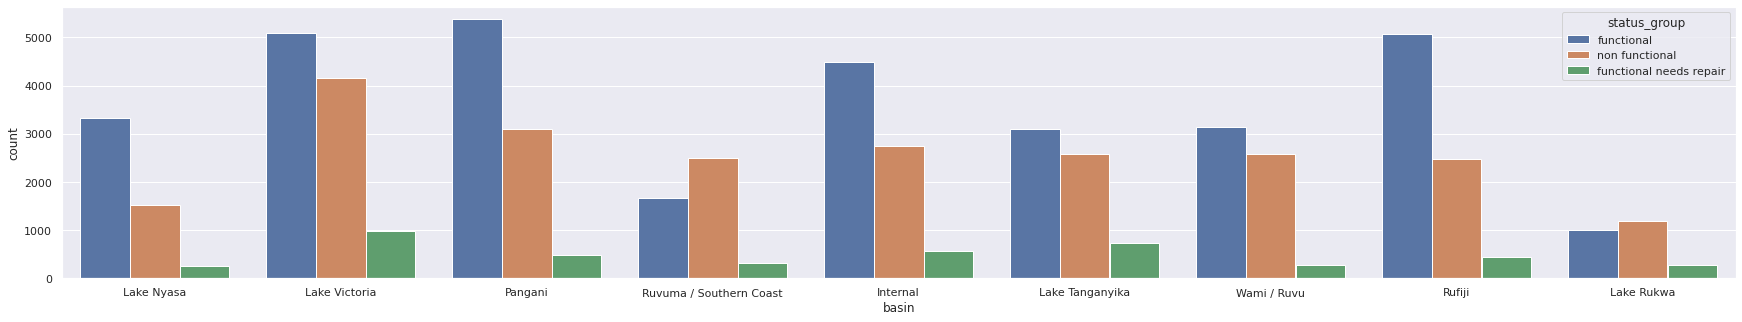

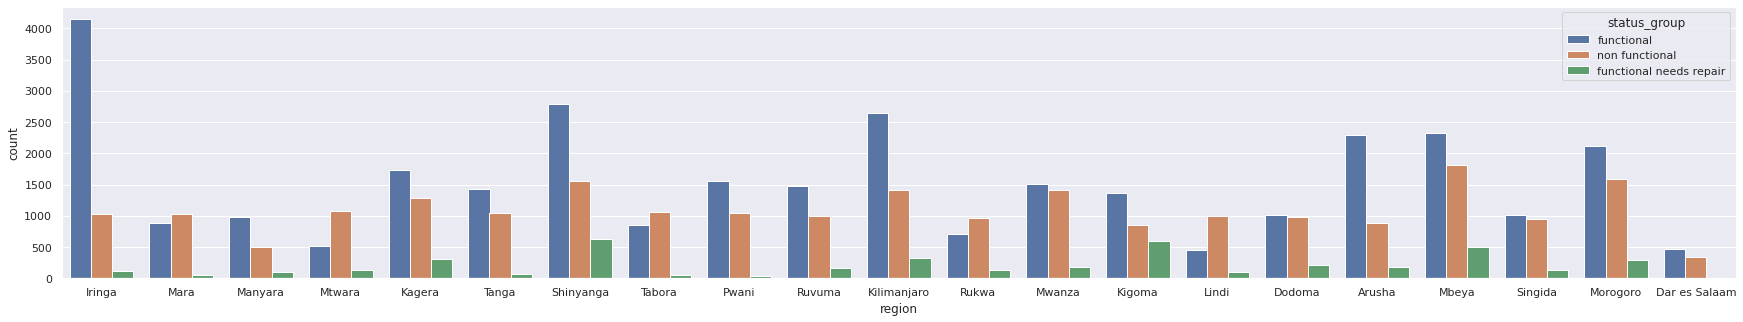

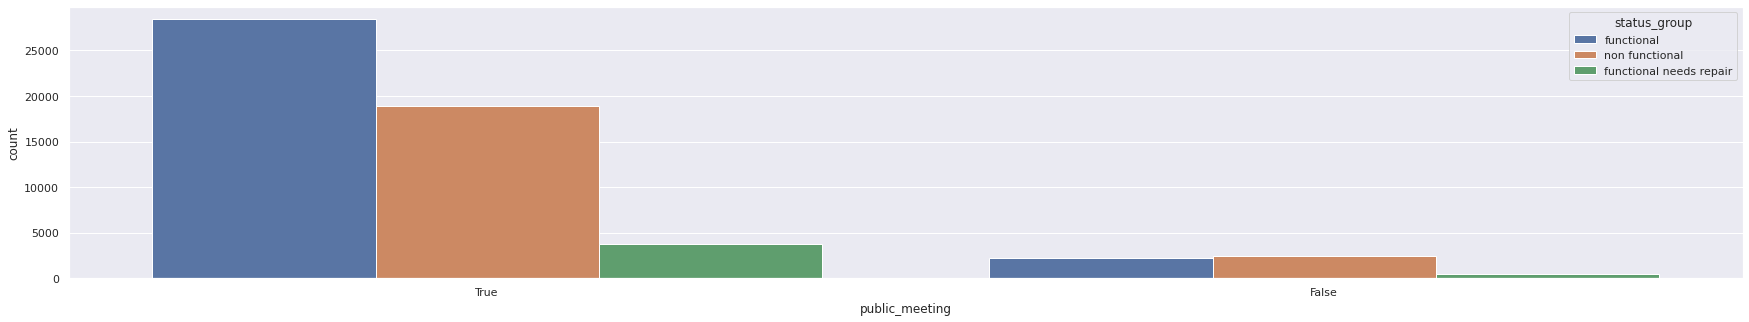

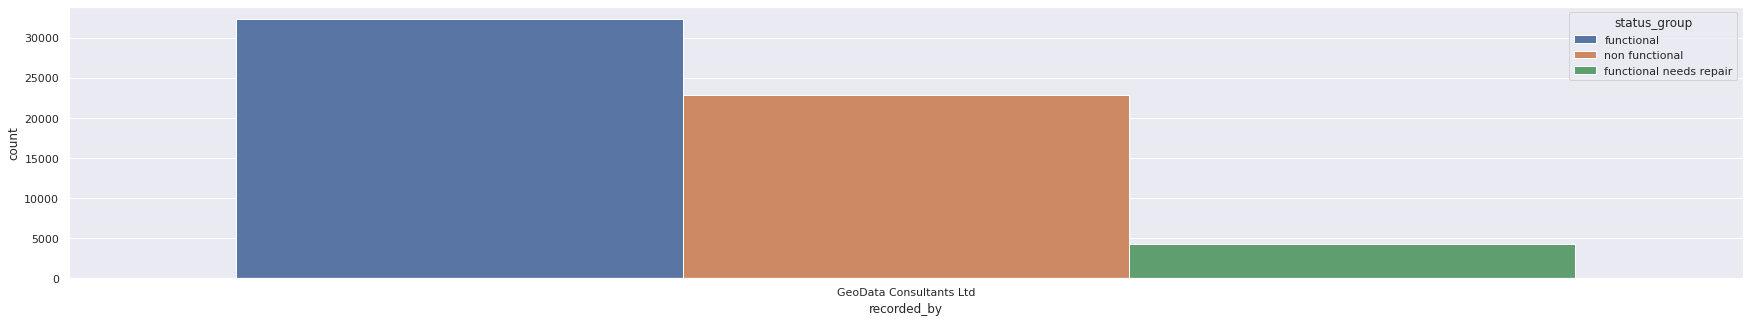

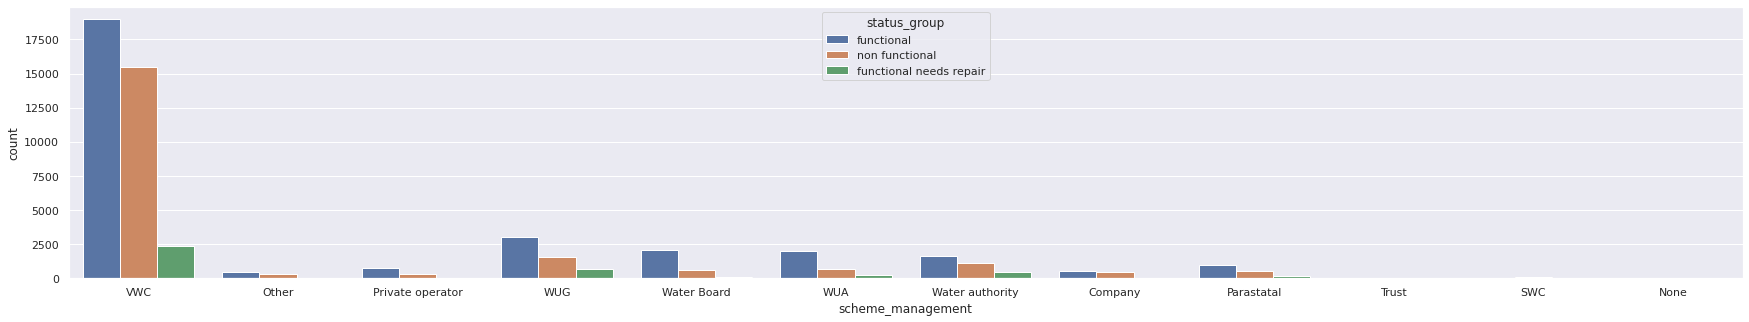

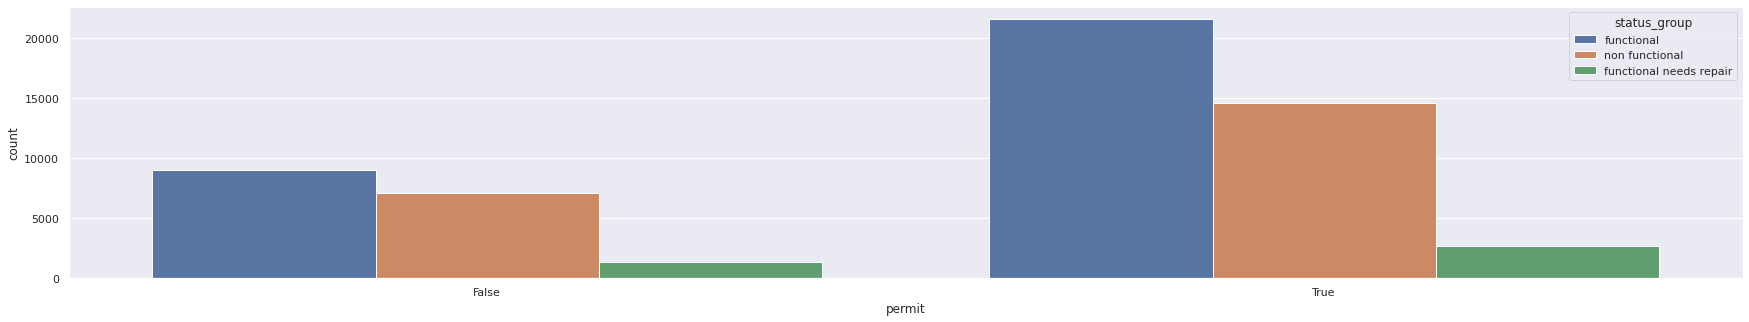

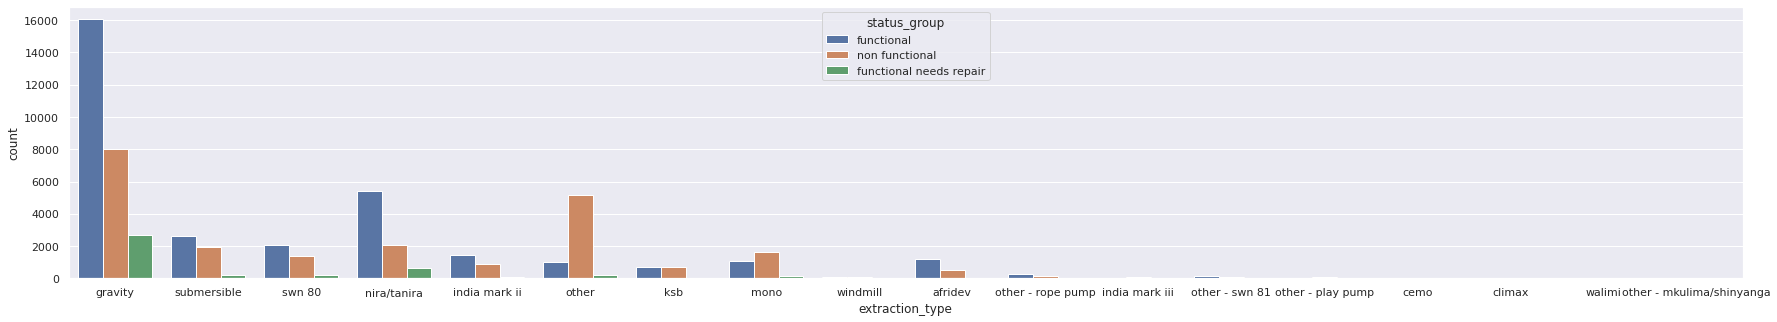

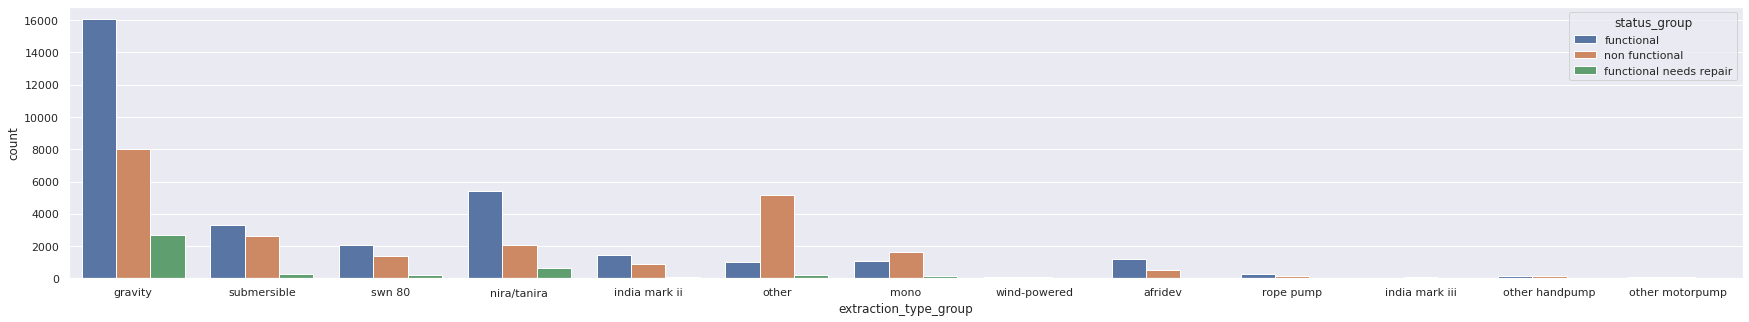

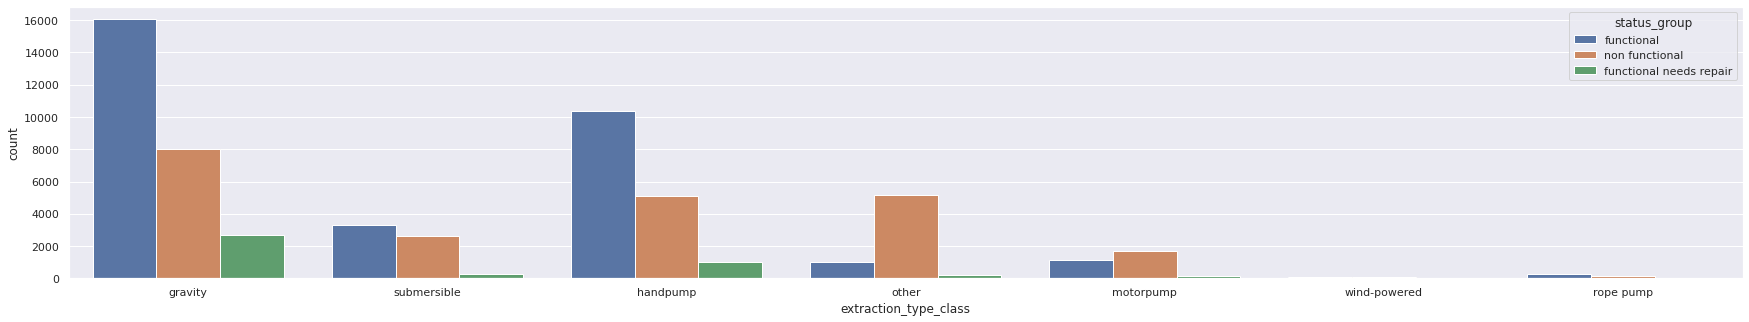

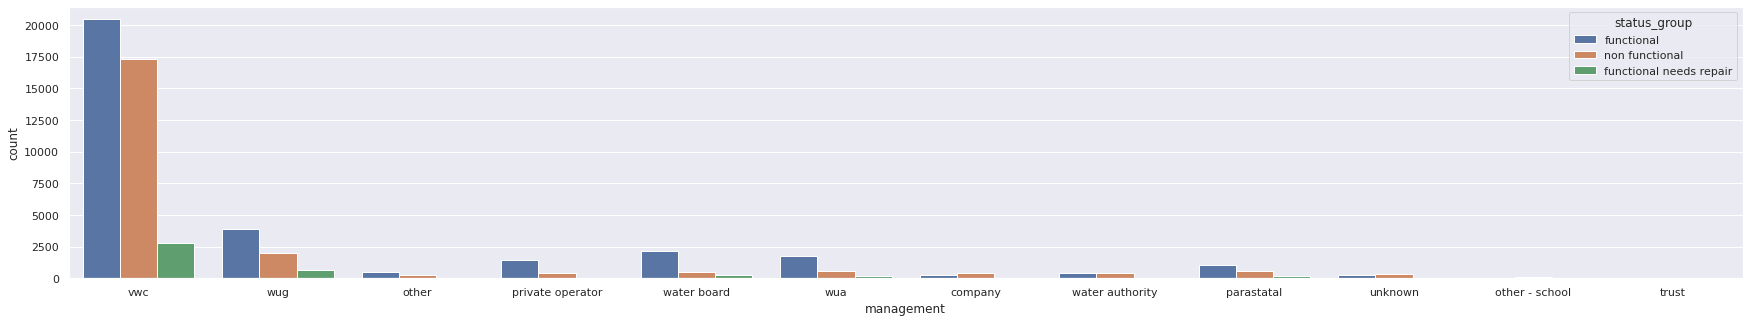

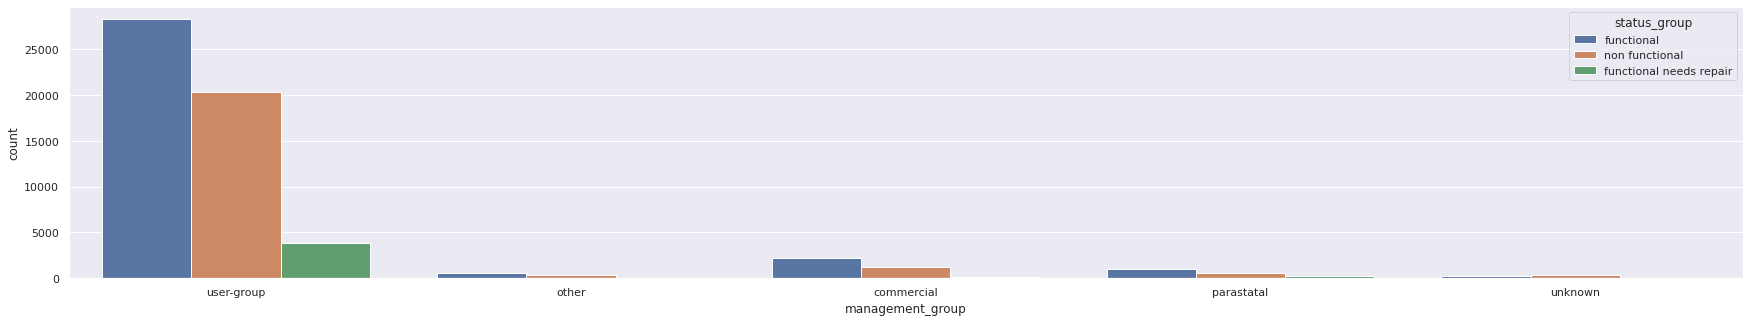

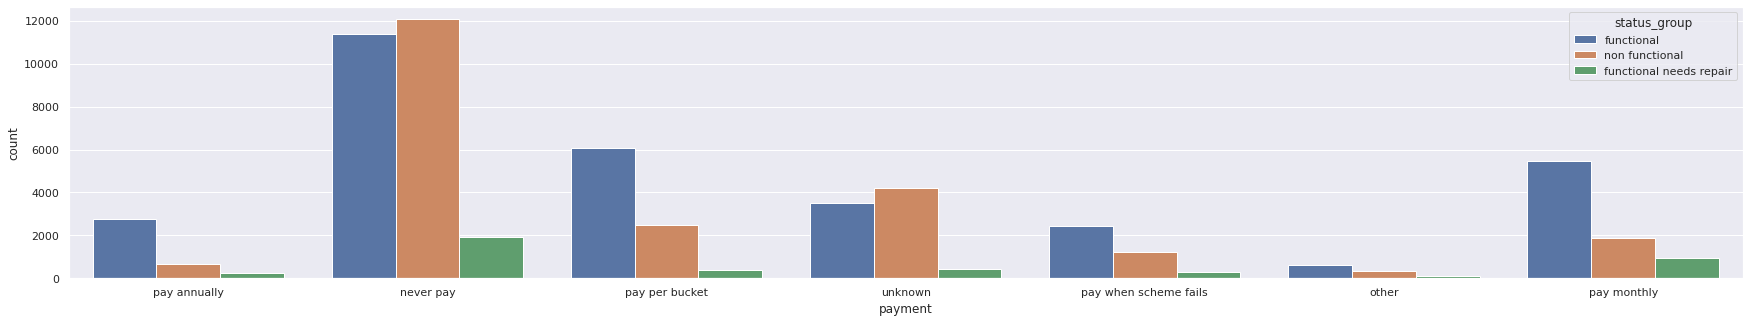

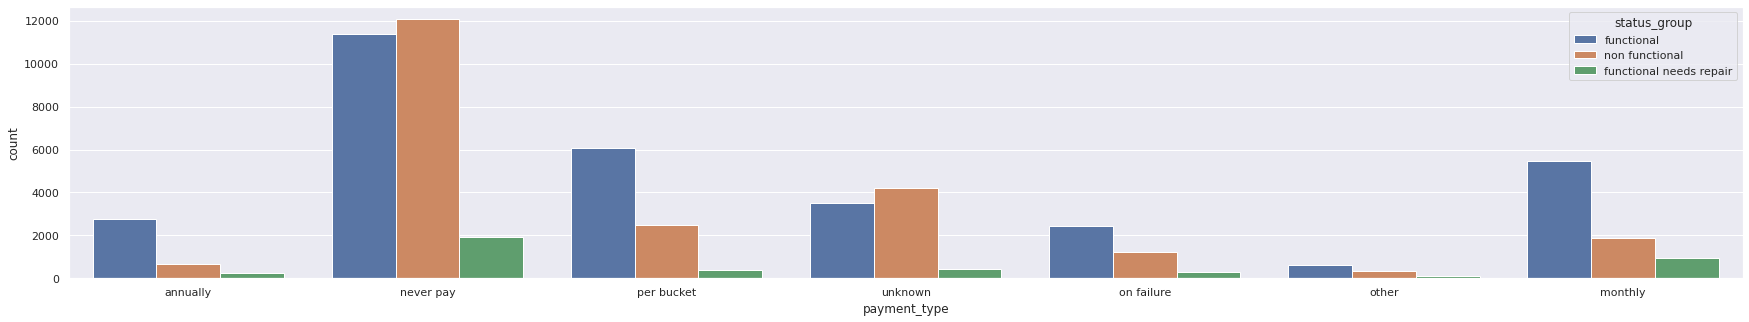

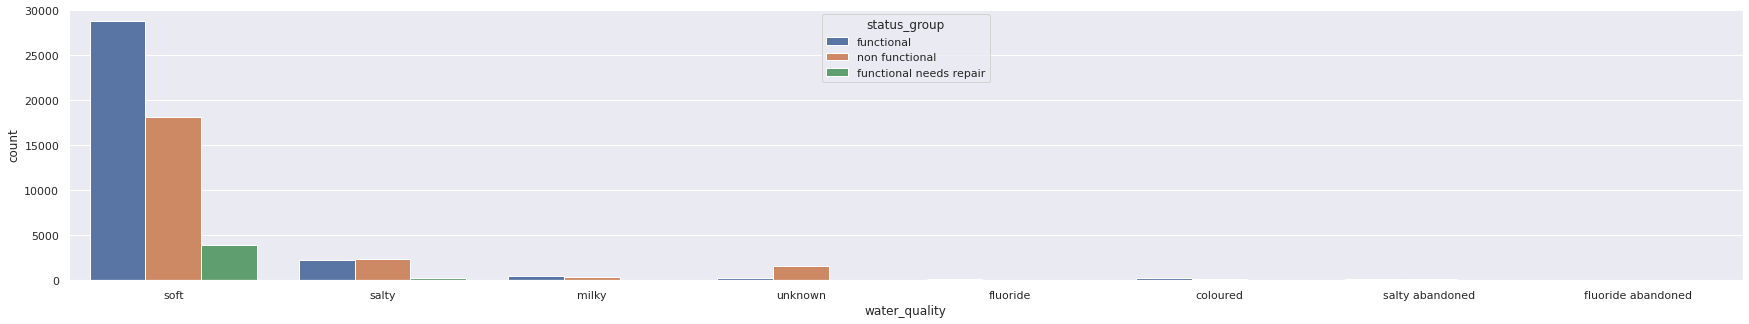

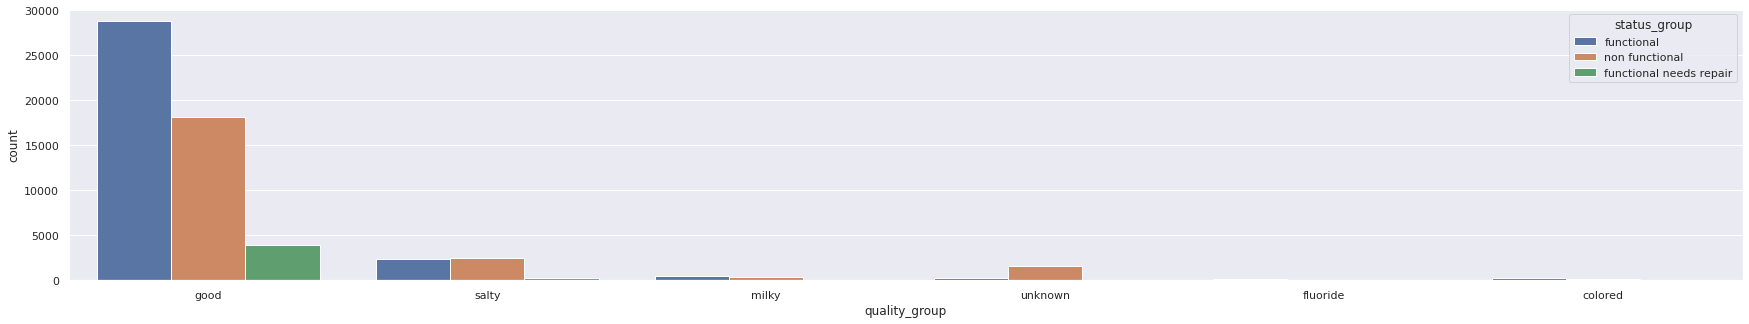

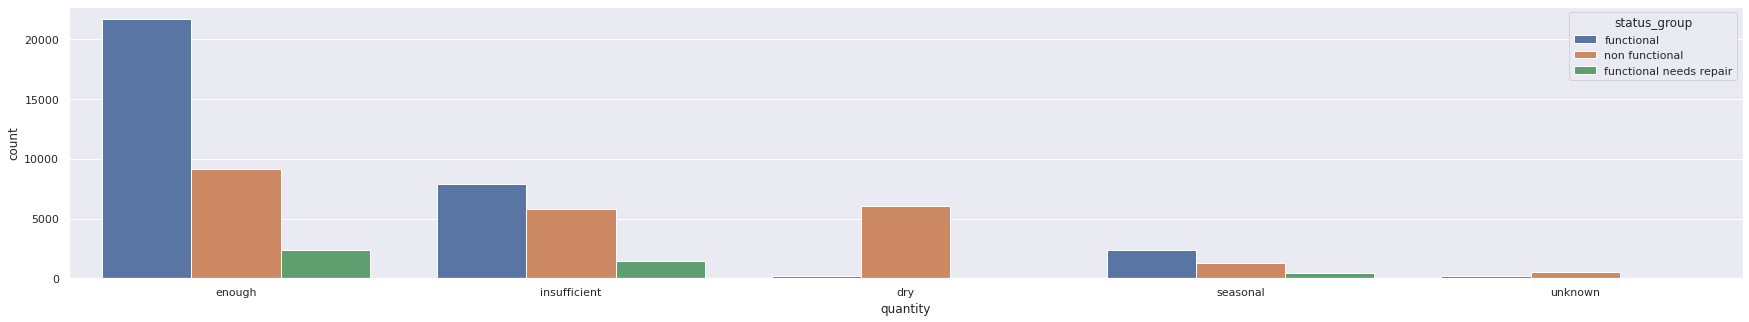

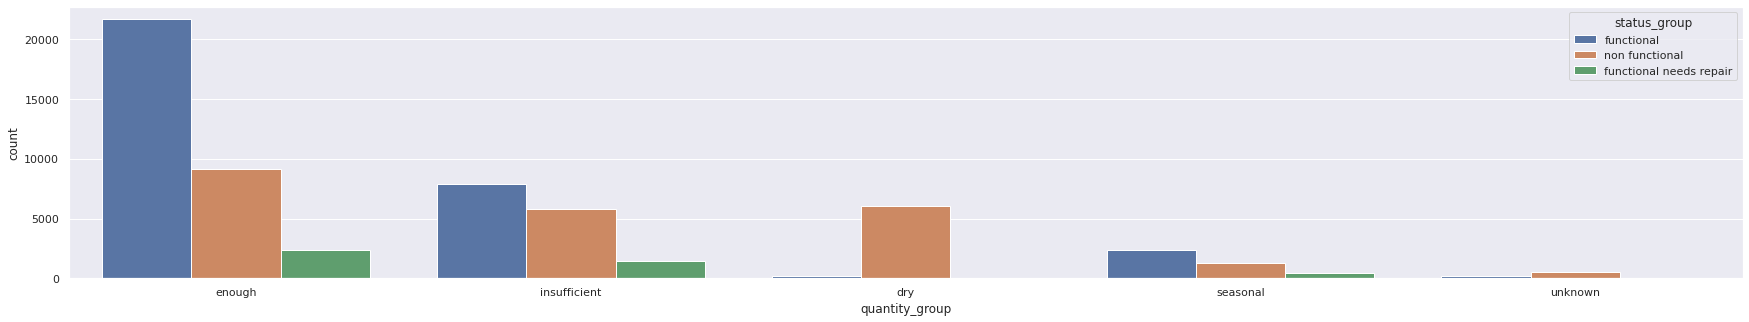

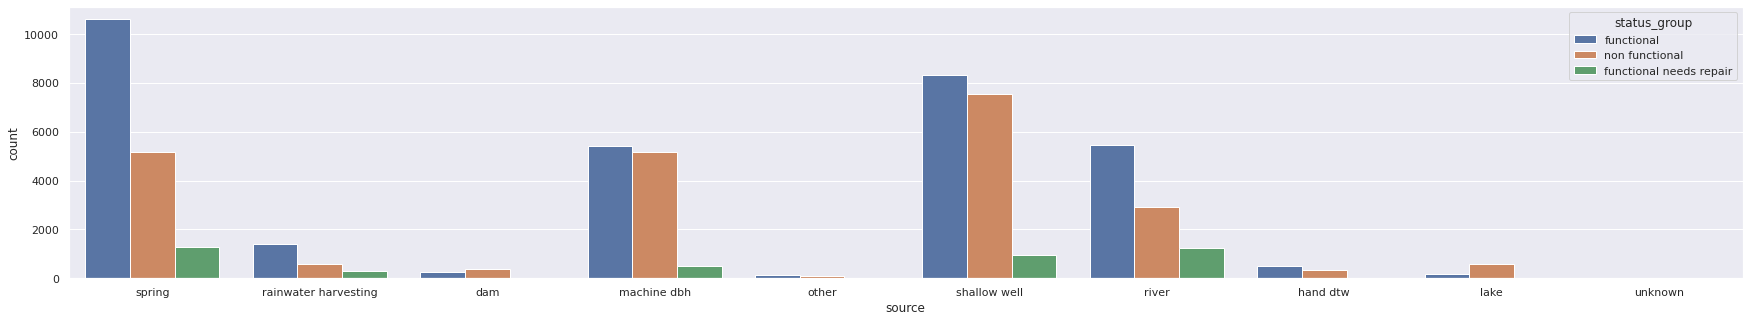

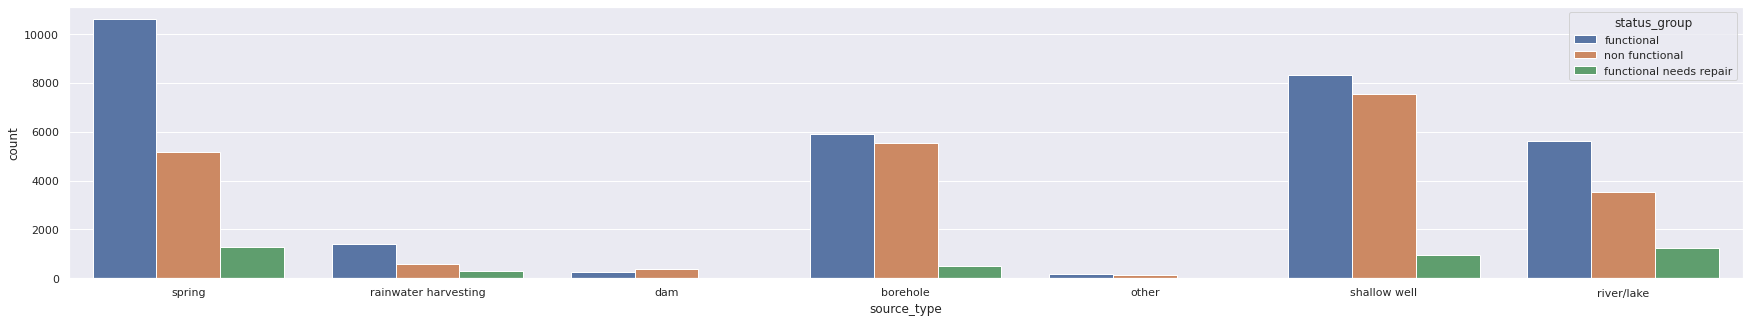

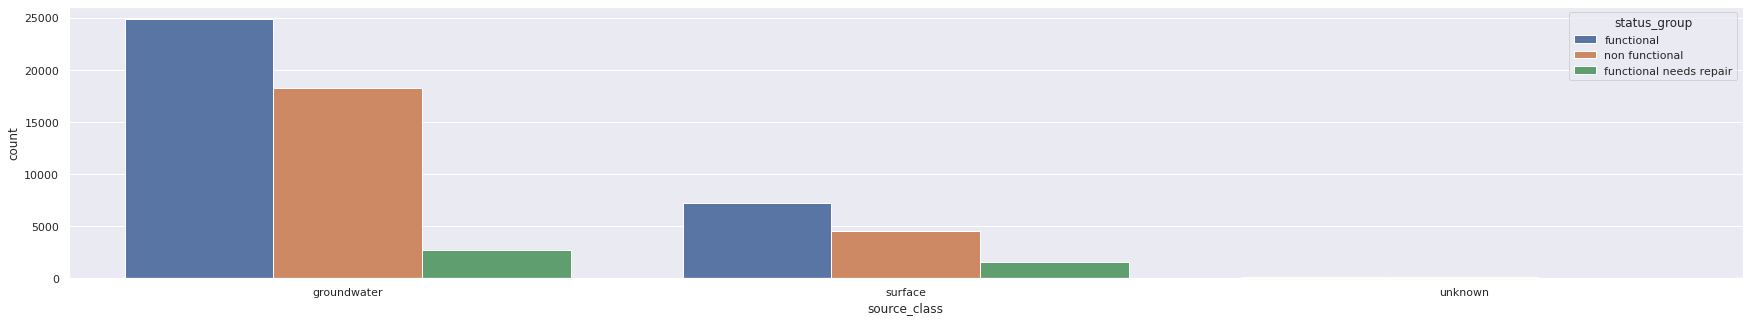

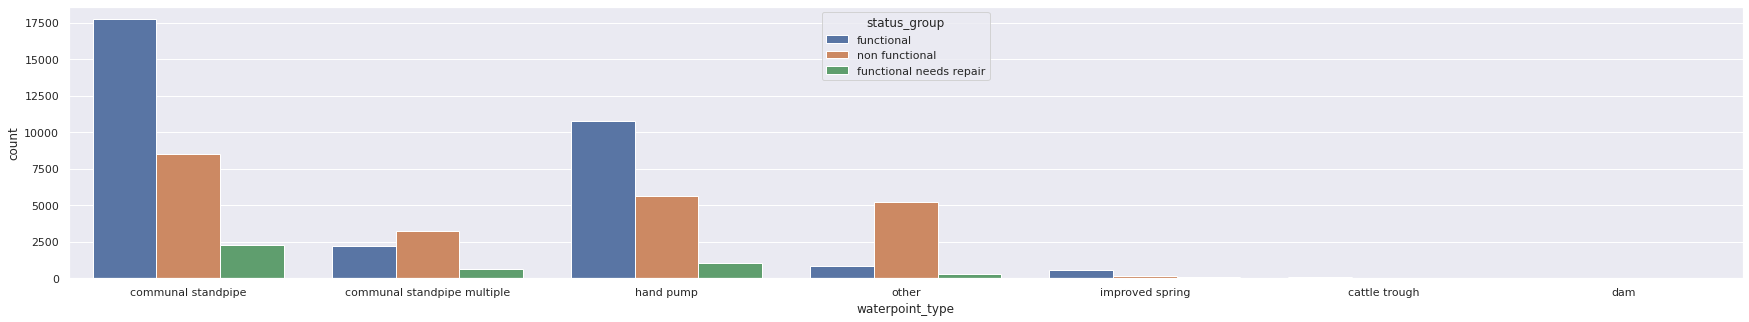

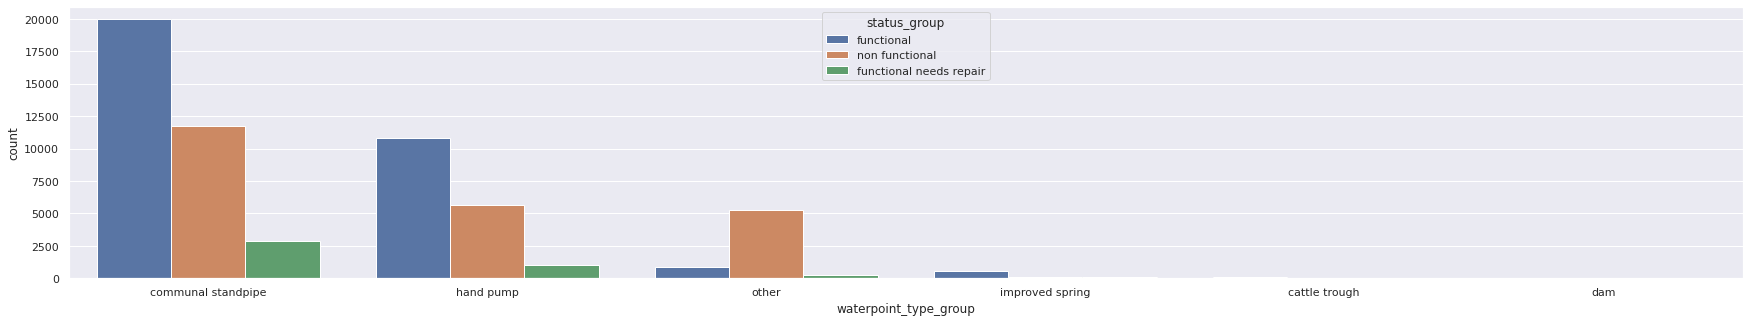

In [ ]:
#plot count plots for categorical columns
sb.set(rc={'figure.figsize':(30.0,5.0)})
for col in plot_cat_cols:
  sb.countplot(x = col, hue = 'status_group', data = joined_df)
  plt.show()

### Finding of NaN (null) values of the categorical features

In [ ]:
features_df[cat_cols].isnull().sum()

date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

In [ ]:
test_df[cat_cols].isnull().sum()

date_recorded               0
funder                    869
installer                 877
wpt_name                    0
basin                       0
subvillage                 99
region                      0
lga                         0
ward                        0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
dtype: int64

In [ ]:
null_cat_cols = features_df[cat_cols].columns[features_df[cat_cols].isna().any()].tolist()
print(null_cat_cols)

['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


In [ ]:
# 'management' and 'scheme_management' values are similar for most cases. 'scheme_management' column's null values can be replace with corrusponding 'management' column's values

### **Numerical features**

In [ ]:
#find numerical columns
num_cols = features_df.columns[features_df.dtypes != "object"].values
print(num_cols)

['amount_tsh' 'gps_height' 'longitude' 'latitude' 'num_private'
 'region_code' 'district_code' 'population' 'construction_year']


In [ ]:
#print('col-name:','district_code',len(features_df[''].unique()))

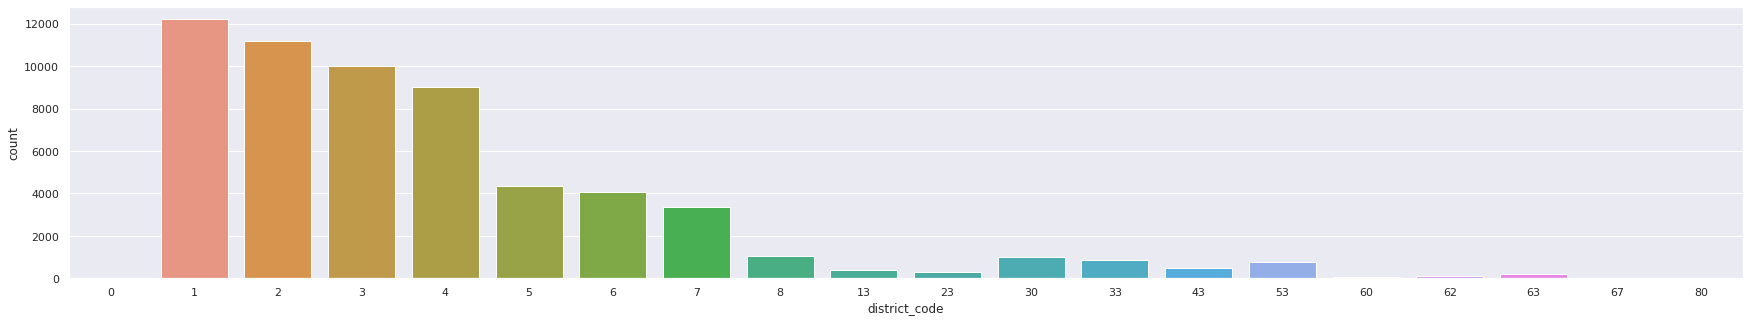

In [ ]:
sb.countplot(x = 'district_code', data = features_df)
plt.show()

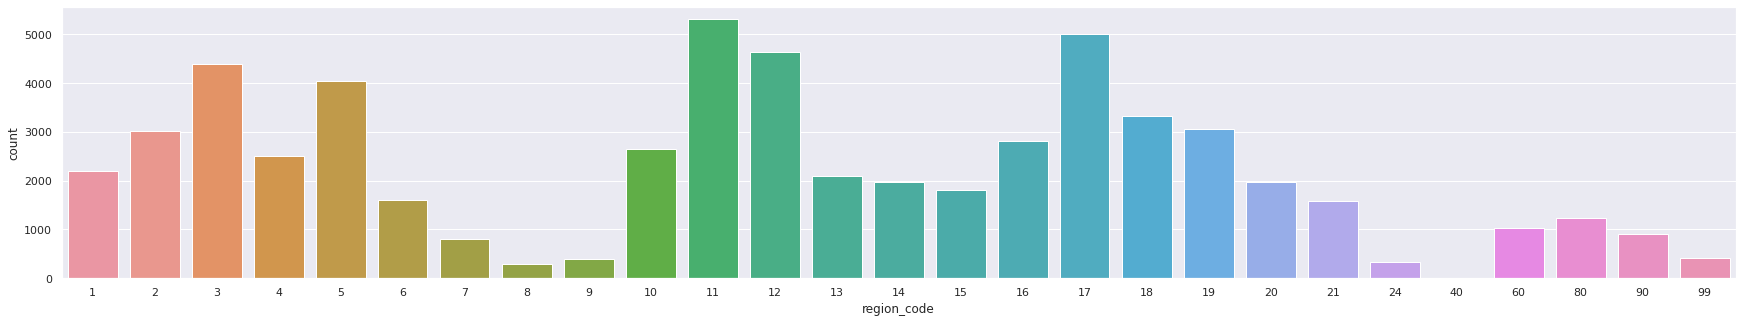

In [ ]:
sb.countplot(x = 'region_code', data = features_df)
plt.show()

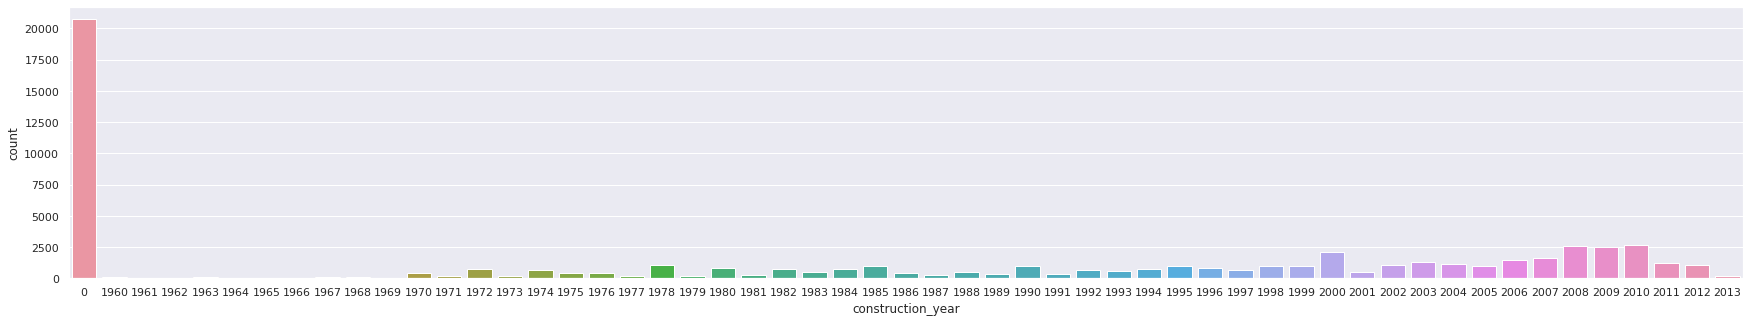

In [ ]:
sb.countplot(x = 'construction_year', data = features_df)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


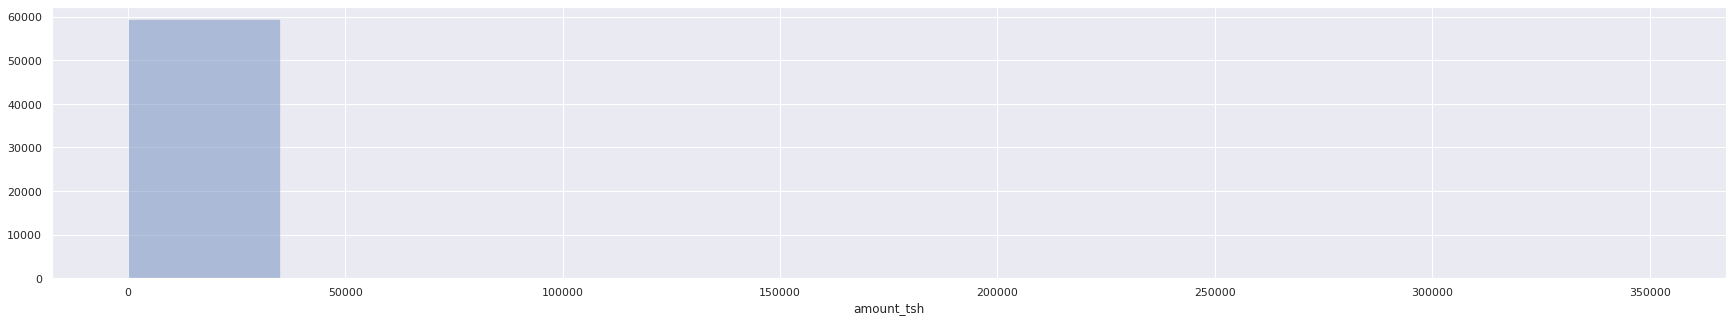

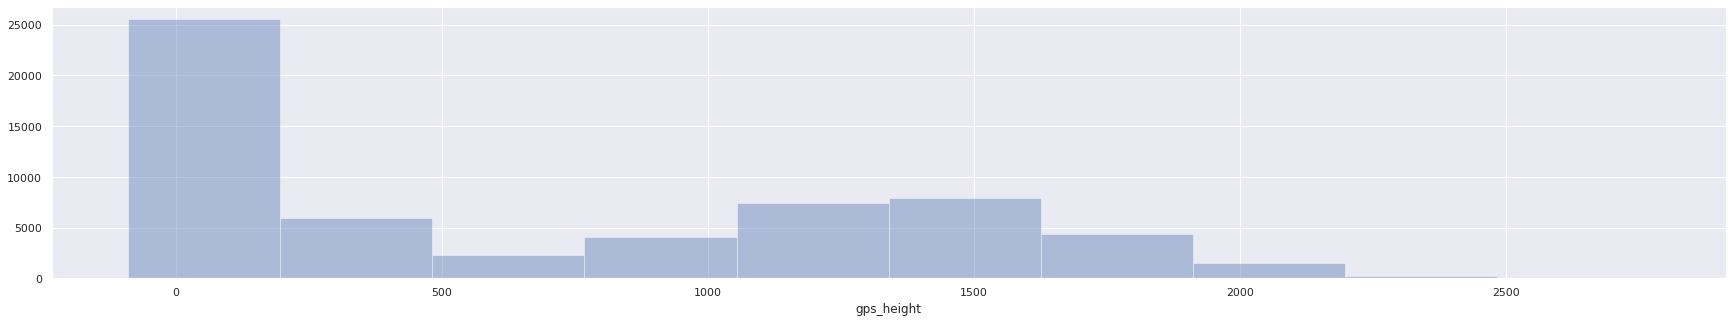

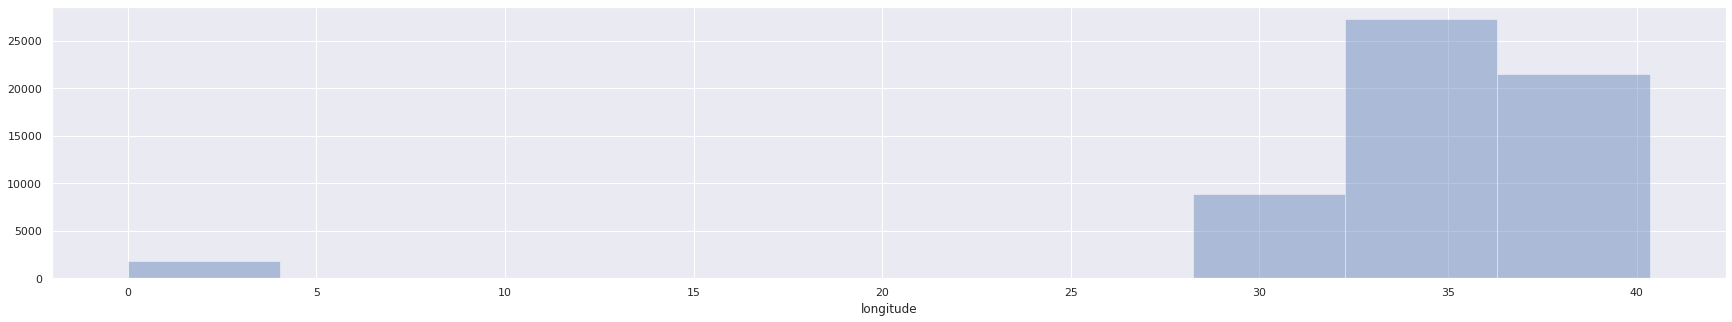

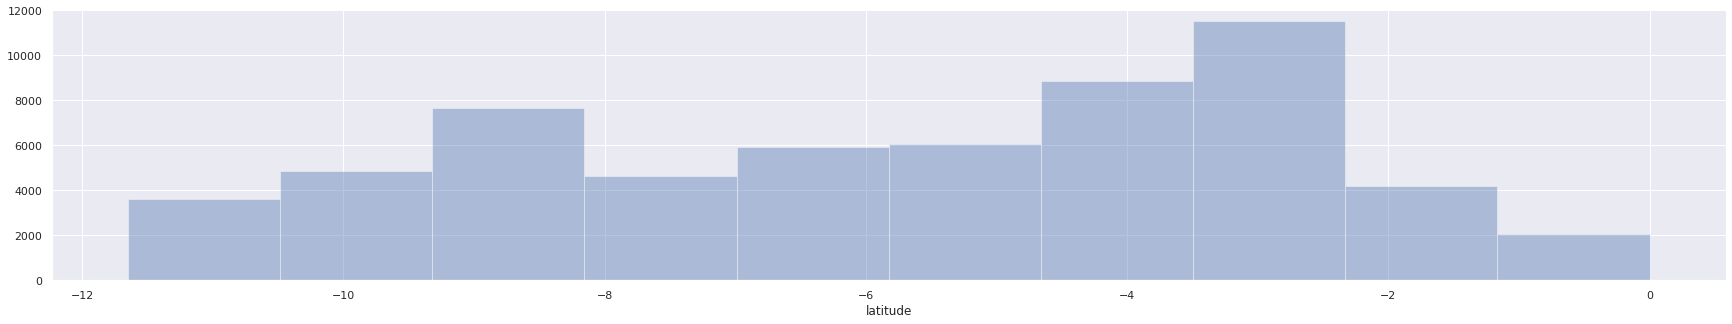

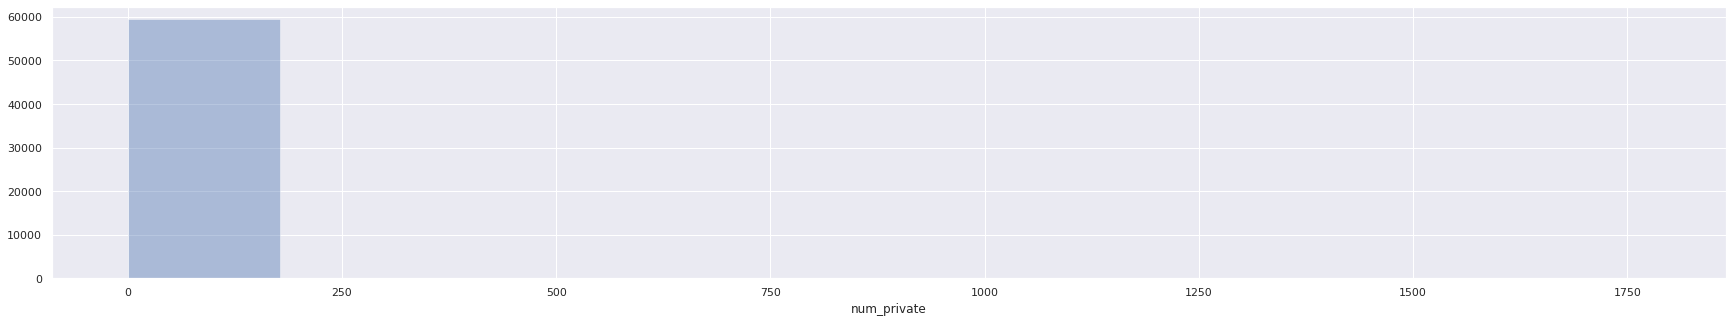

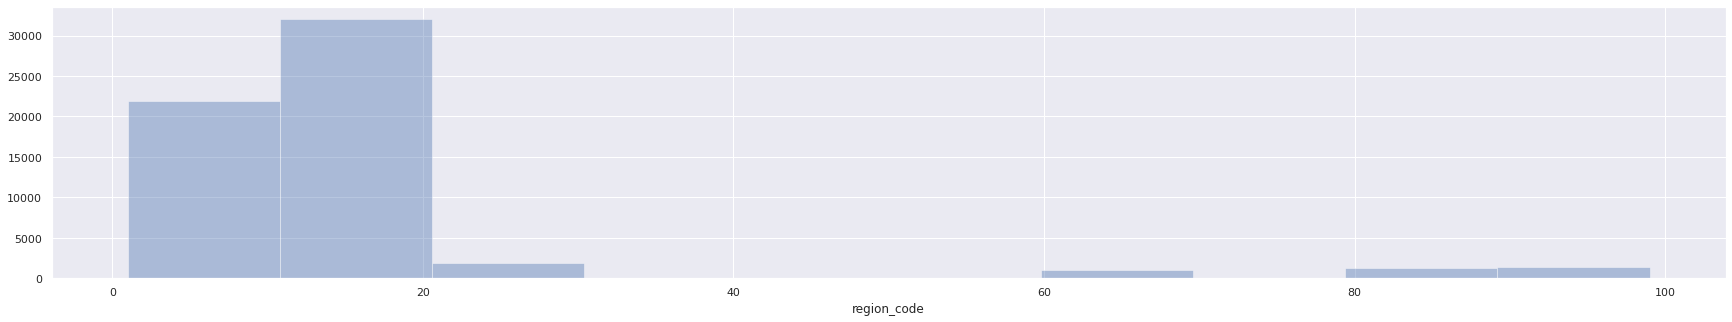

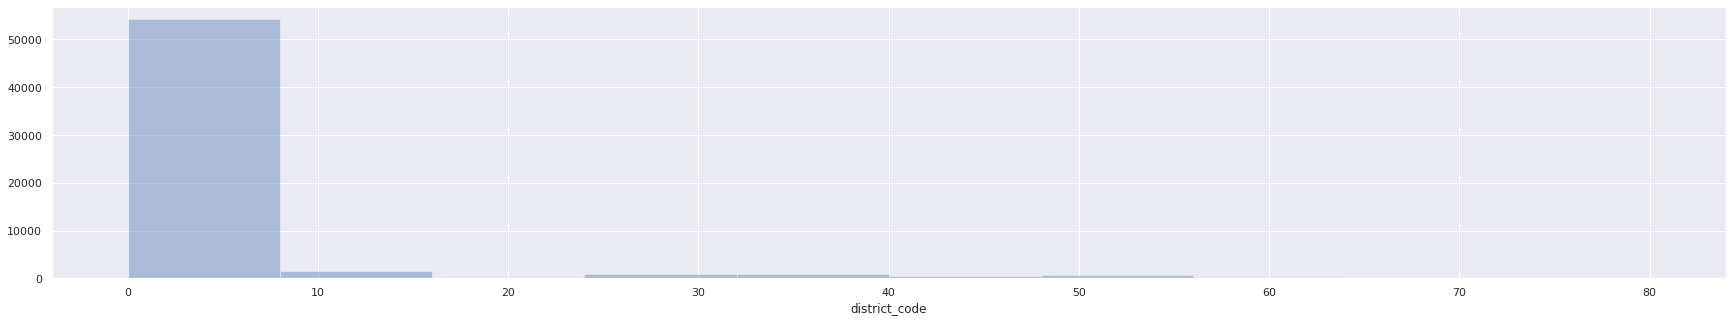

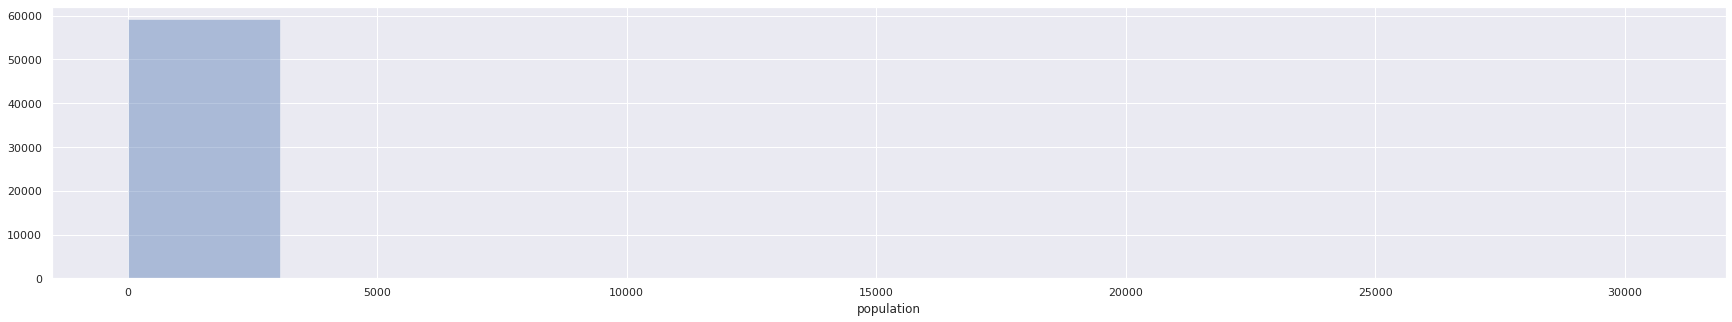

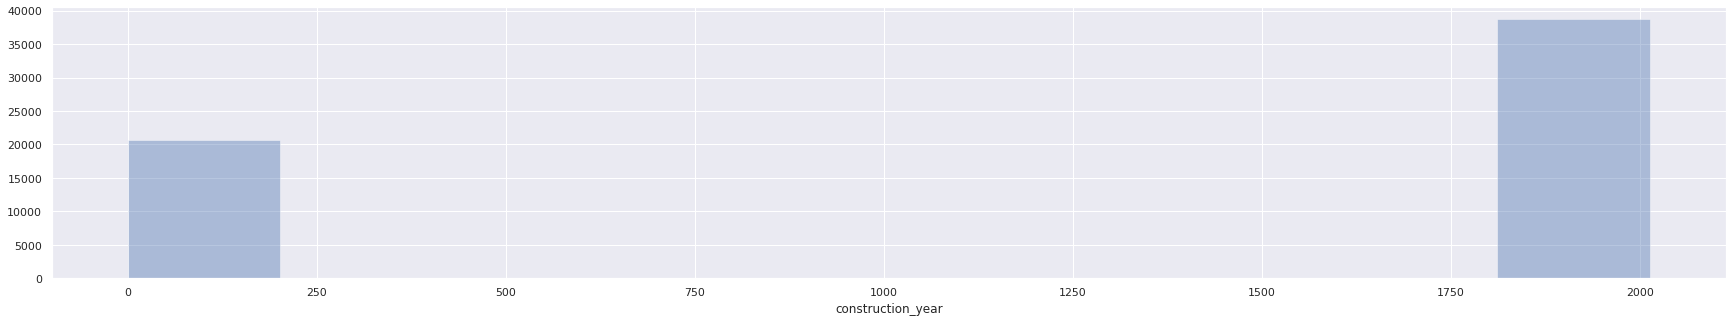

In [ ]:
#Visualize numerical features

for col in num_cols:
  sb.distplot(features_df[col],kde = False, bins = 10)
  plt.show()

In [ ]:
# check for nan values in numerical features
features_df[num_cols].isnull().sum()

amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

### Outlier Analysis

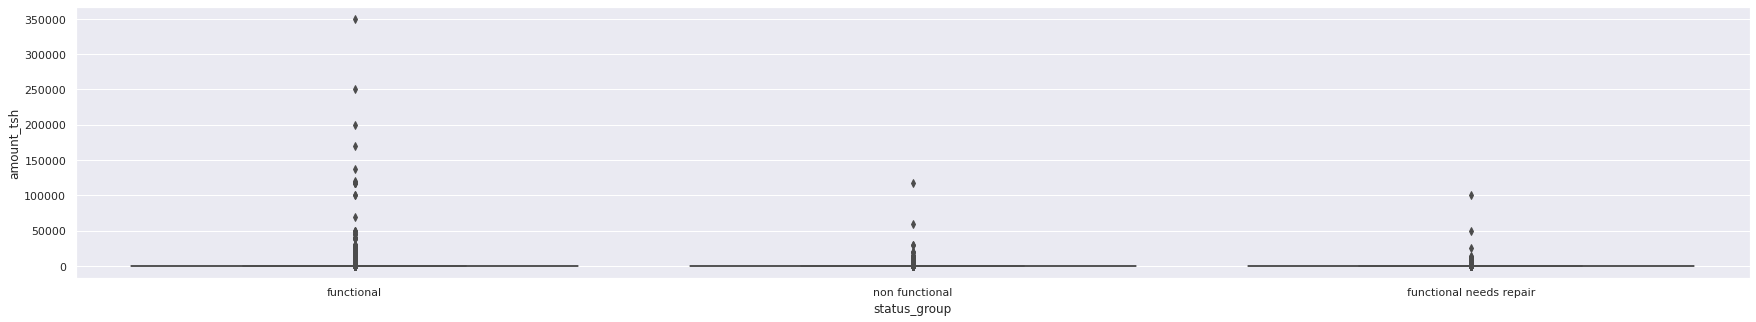

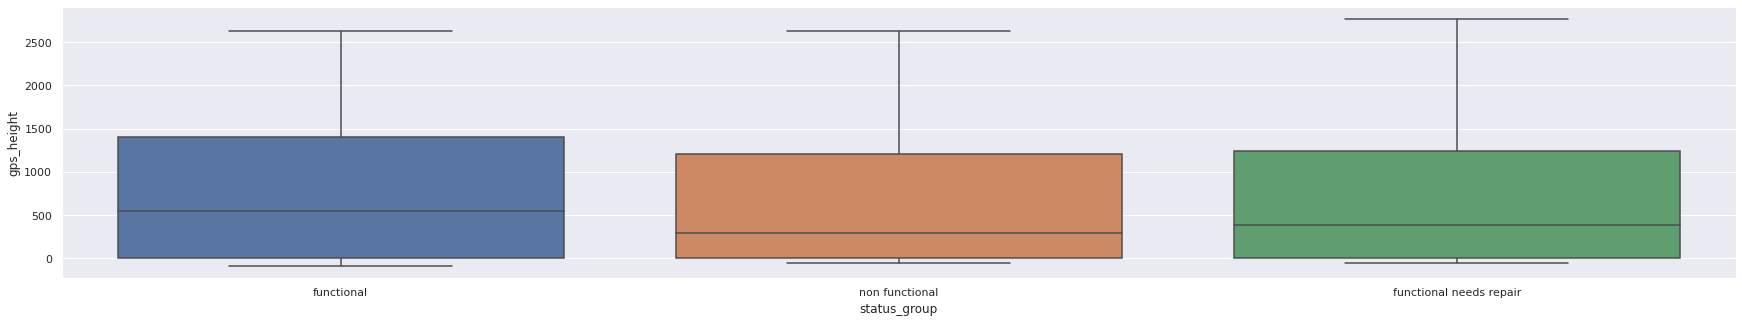

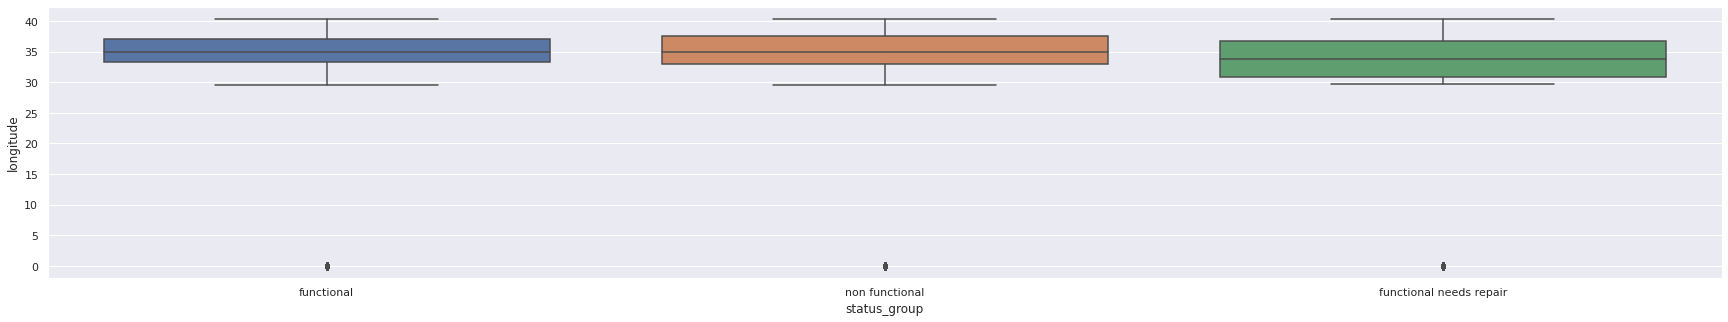

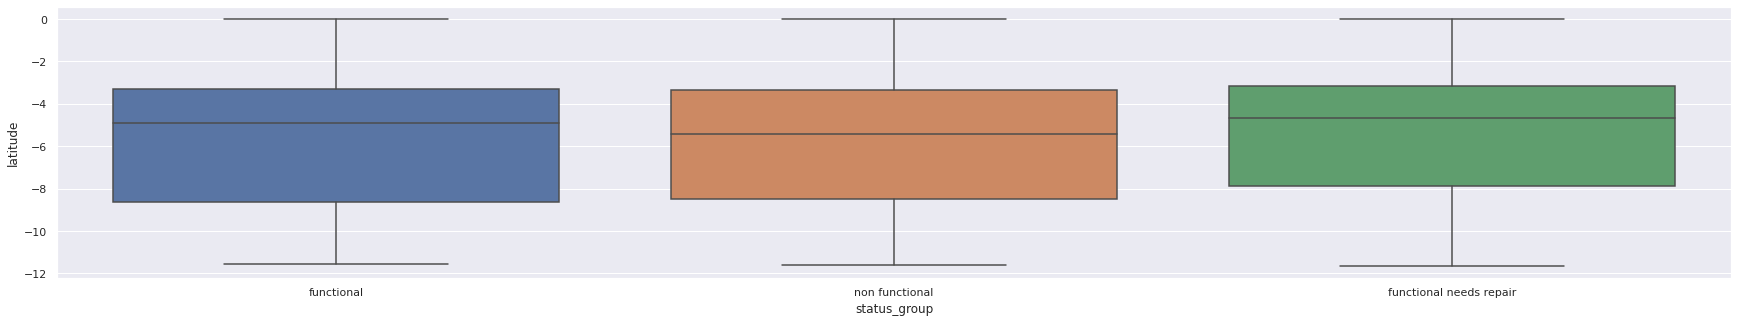

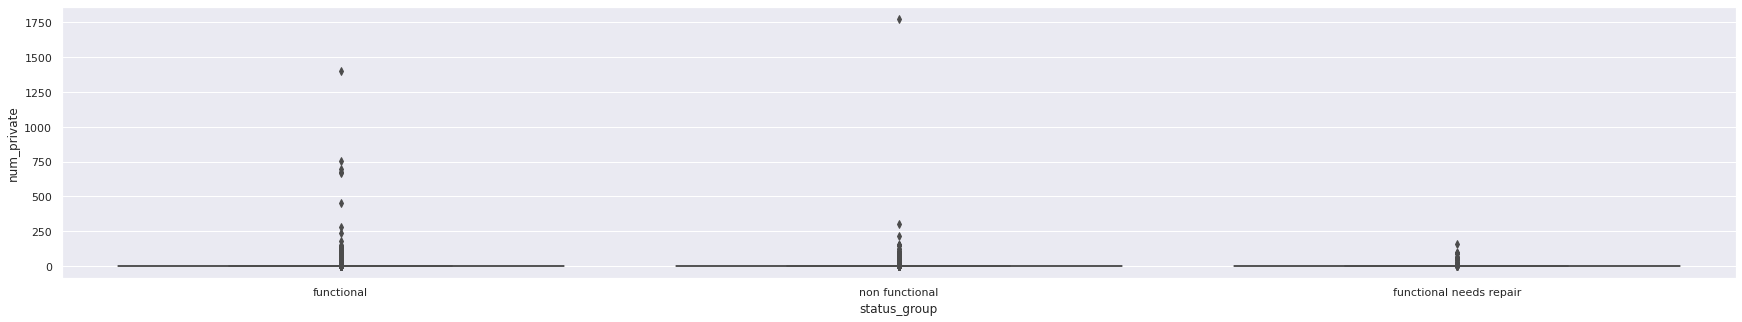

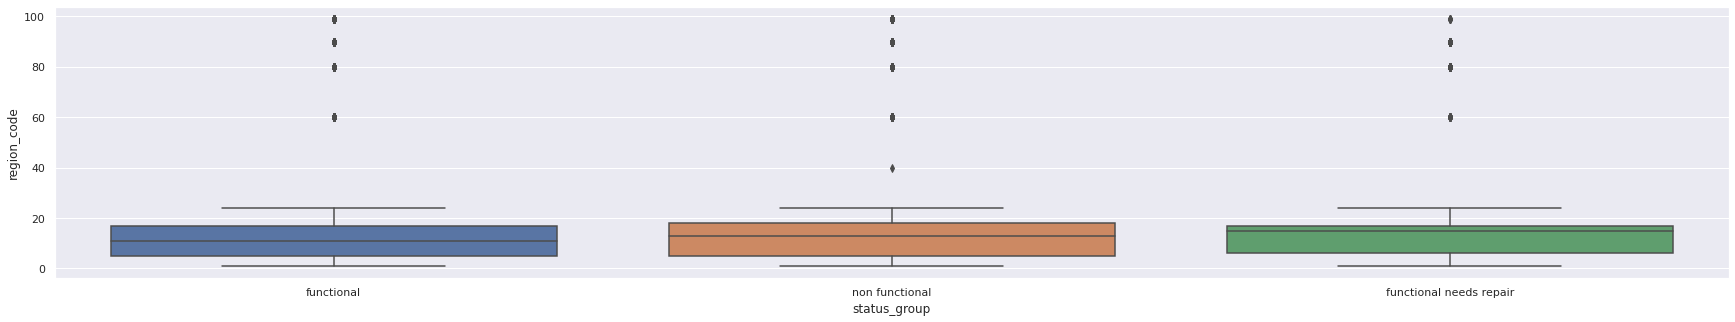

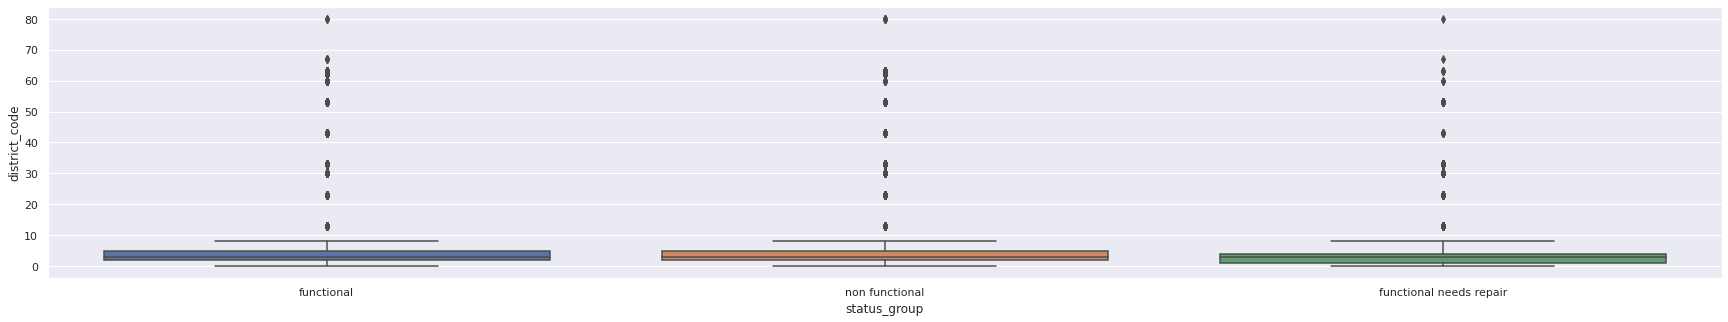

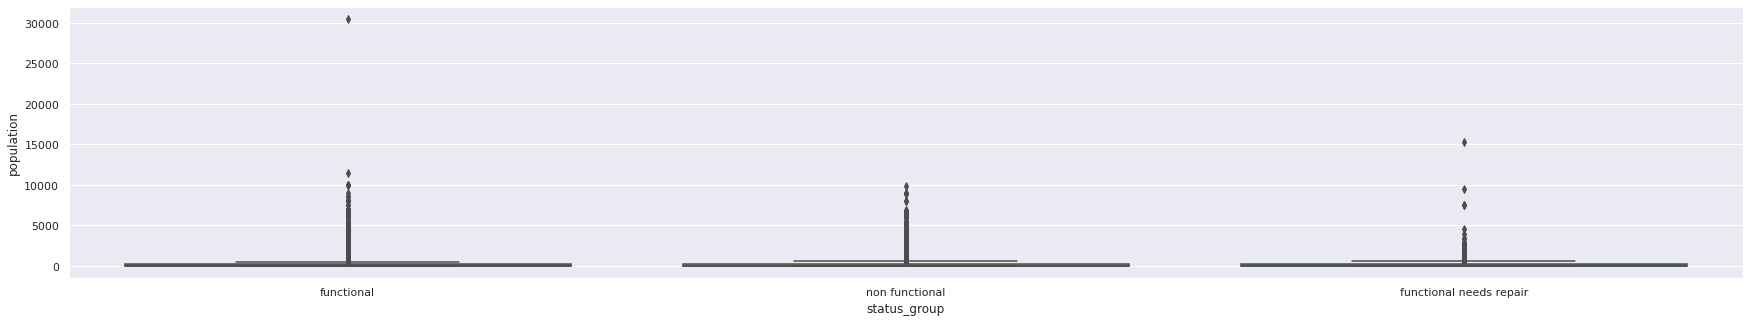

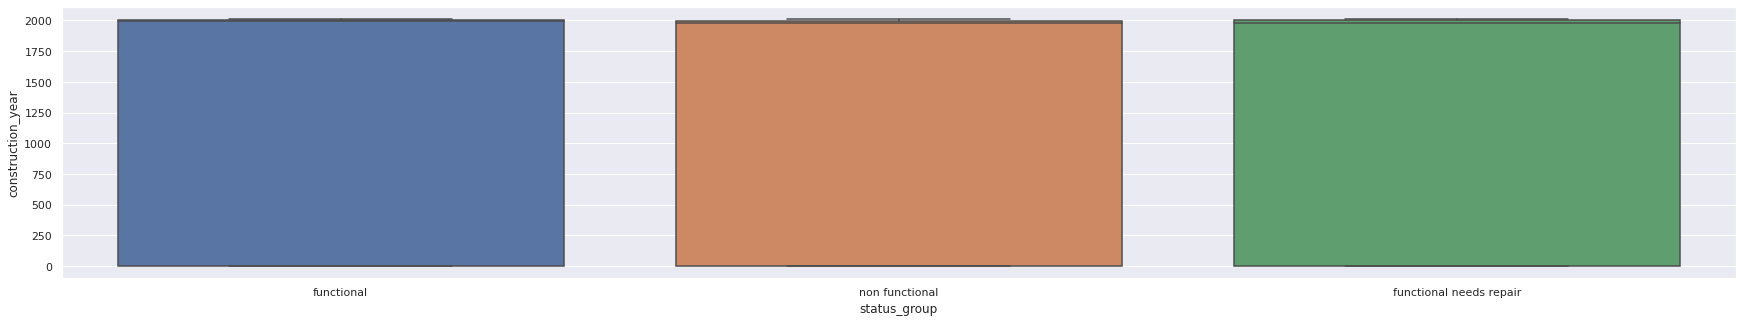

In [ ]:
for col in num_cols:
  sb.boxplot(x="status_group", y=col, data=joined_df)
  plt.show()

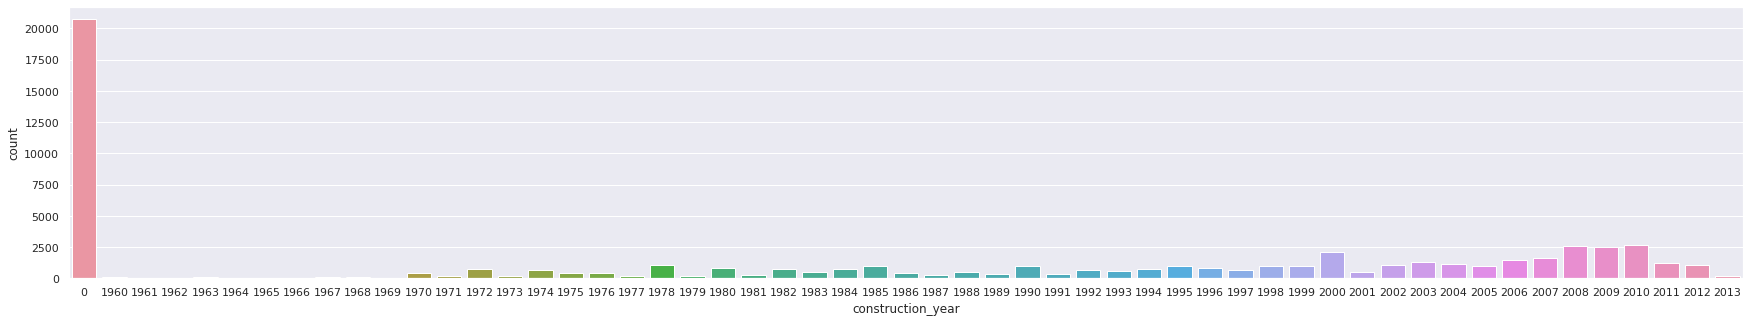

In [ ]:
sb.countplot(x = 'construction_year', data = features_df)
plt.show()

### **Decisions after exploring the data manually**

**High categorical cardinality**
*   'date_recorded' will be grouped year-wise or half_year-wise and then perform label encoding.
*   'wpt_name' and 'subvillage' will be removed from input dataset as the higher categorical cardinality. Cannot expect info gain from those features.  **done**

**Duplicate features**
* 'region' and 'region_code' ----> 'region' will be removed. **done**
* 'management' and 'scheme_management' -------> after impute the NaN values, two features will be merged into one.
* from 'extraction_type', 'extraction_type_group', 'extraction_type_class' will select one. **done**
* 'payment' and 'payment_type'  ------> 'payment' will be removed. **done**
* from 'quantity' and 'quantity_group' --------> 'quantity_group' will be removed.  **done**
* from 'source' and 'source_type' will select a one.  **done**
* from 'waterpoint_type' and 'waterpoint_type_group' ---------> 'waterpoint_type_group' will be removed  **done**





###Note
'district_code' and 'region_code' are not continous values. They are more like categorical.

'num_private' only have 0 as values. So that column should drop. **done**

In [ ]:
#make copies of original datasets
features_dfcp = features_df.copy()
test_dfcp = test_df.copy()
joined_dfcp = joined_df.copy()
labels_dfcp = labels_df.copy()

##Remove duplicates and unnecessary columns

In [ ]:
# removing columns
rm_cols = ['wpt_name', 'subvillage', 'region', 'extraction_type_group', 'extraction_type_class', 'payment', 'quantity_group', 'source_type', 'waterpoint_type_group', 'num_private', 'recorded_by']

In [ ]:
for col in rm_cols:
  features_dfcp.drop(col, axis='columns', inplace=True)
  test_dfcp.drop(col, axis='columns', inplace=True)
  joined_dfcp.drop(col, axis='columns', inplace=True)

#Handling outliers

In [ ]:
(features_df['construction_year']==0).sum()

20709

consruction year is marked as 0 for most of the cases. This could be happen due to a lack of information at the time the data collected. will check the performances with and without imputations for 0 values.

In [ ]:
(features_df['population']==0).sum()

21381

population can be zero in my opinion. will check the performances with and without imputations for 0 values.

In [ ]:
(features_df['gps_height']==0).sum()

20438

As the gps_height is a distance measurement respect to a reference, 0 value is valid measurement. So we cannot be surely conclude that as an oulier. will check the performances with and without impuatations.

In [ ]:
(features_df['longitude']==0).sum()

1812

According the distplots and boxplots, we can clearly see that these 0 values of 'longitude' are more like outliers. Imputation techniques should apply here.

In [ ]:
(features_df['amount_tsh']==0).sum()

41639

After exploring the dataframe manually, it can be seen that '0' values appears in all the above features are not a coincidence. Most of the time '0' values are appear in the same raws. So it would be better if we use impuatation technique for those values.

In [ ]:
zero_cols = ['amount_tsh', 'longitude', 'gps_height', 'population', 'construction_year']

In [ ]:
#replace 0 values with NaN
#for col in zero_cols:
#  features_dfcp[col].replace(0.0, np.nan, inplace=True)
#  test_dfcp[col].replace(0.0, np.nan, inplace=True)
#  joined_dfcp[col].replace(0.0, np.nan, inplace=True)


### Replace 0 values

In [ ]:
features_dfcp["gps_height"].fillna(features_dfcp.groupby(['region_code', 'district_code'])["gps_height"].transform("mean"), inplace=True)
features_dfcp["gps_height"].fillna(features_dfcp.groupby(['region_code'])["gps_height"].transform("mean"), inplace=True)
features_dfcp["gps_height"].fillna(features_dfcp.groupby(['district_code'])["gps_height"].transform("mean"), inplace=True)
features_dfcp["gps_height"].fillna(features_dfcp['gps_height'].mean(), inplace=True)


features_dfcp["longitude"].fillna(features_dfcp.groupby(['region_code', 'district_code'])["longitude"].transform("mean"), inplace=True)
features_dfcp["longitude"].fillna(features_dfcp.groupby(['region_code'])["longitude"].transform("mean"), inplace=True)
features_dfcp["longitude"].fillna(features_dfcp.groupby(['district_code'])["longitude"].transform("mean"), inplace=True)
features_dfcp["longitude"].fillna(features_dfcp['longitude'].mean(), inplace=True)


features_dfcp["population"].fillna(features_dfcp.groupby(['region_code', 'district_code'])["population"].transform("median"), inplace=True)
features_dfcp["population"].fillna(features_dfcp.groupby(['region_code'])["population"].transform("median"), inplace=True)
features_dfcp["population"].fillna(features_dfcp.groupby(['district_code'])["population"].transform("median"), inplace=True)
features_dfcp["population"].fillna(features_dfcp['population'].median(), inplace=True)


features_dfcp["amount_tsh"].fillna(features_dfcp.groupby(['region_code', 'district_code', 'basin'])["amount_tsh"].transform("mean"), inplace=True)
features_dfcp["amount_tsh"].fillna(features_dfcp.groupby(['district_code', 'basin'])["amount_tsh"].transform("mean"), inplace=True)
features_dfcp["amount_tsh"].fillna(features_dfcp.groupby(['basin'])["amount_tsh"].transform("mean"), inplace=True)
features_dfcp["amount_tsh"].fillna(features_dfcp['amount_tsh'].mean(), inplace=True)


features_dfcp["construction_year"].fillna(features_dfcp.groupby(['basin', 'funder'])["construction_year"].transform("mean"), inplace=True)
features_dfcp["construction_year"].fillna(features_dfcp.groupby(['funder'])["construction_year"].transform("mean"), inplace=True)
features_dfcp["construction_year"].fillna(features_dfcp['construction_year'].mean(), inplace=True)


test_dfcp["gps_height"].fillna(test_dfcp.groupby(['region_code', 'district_code'])["gps_height"].transform("mean"), inplace=True)
test_dfcp["gps_height"].fillna(test_dfcp.groupby(['region_code'])["gps_height"].transform("mean"), inplace=True)
test_dfcp["gps_height"].fillna(test_dfcp.groupby(['district_code'])["gps_height"].transform("mean"), inplace=True)
test_dfcp["gps_height"].fillna(test_dfcp['gps_height'].mean(), inplace=True)


test_dfcp["longitude"].fillna(test_dfcp.groupby(['region_code', 'district_code'])["longitude"].transform("mean"), inplace=True)
test_dfcp["longitude"].fillna(test_dfcp.groupby(['region_code'])["longitude"].transform("mean"), inplace=True)
test_dfcp["longitude"].fillna(test_dfcp.groupby(['district_code'])["longitude"].transform("mean"), inplace=True)
test_dfcp["longitude"].fillna(test_dfcp['longitude'].mean(), inplace=True)


test_dfcp["population"].fillna(test_dfcp.groupby(['region_code', 'district_code'])["population"].transform("median"), inplace=True)
test_dfcp["population"].fillna(test_dfcp.groupby(['region_code'])["population"].transform("median"), inplace=True)
test_dfcp["population"].fillna(test_dfcp.groupby(['district_code'])["population"].transform("median"), inplace=True)
test_dfcp["population"].fillna(test_dfcp['population'].median(), inplace=True)


test_dfcp["amount_tsh"].fillna(test_dfcp.groupby(['region_code', 'district_code', 'basin'])["amount_tsh"].transform("mean"), inplace=True)
test_dfcp["amount_tsh"].fillna(test_dfcp.groupby(['district_code', 'basin'])["amount_tsh"].transform("mean"), inplace=True)
test_dfcp["amount_tsh"].fillna(test_dfcp.groupby(['basin'])["amount_tsh"].transform("mean"), inplace=True)
test_dfcp["amount_tsh"].fillna(test_dfcp['amount_tsh'].mean(), inplace=True)


test_dfcp["construction_year"].fillna(test_dfcp.groupby(['basin', 'funder'])["construction_year"].transform("mean"), inplace=True)
test_dfcp["construction_year"].fillna(test_dfcp.groupby(['funder'])["construction_year"].transform("mean"), inplace=True)
test_dfcp["construction_year"].fillna(test_dfcp['construction_year'].mean(), inplace=True)


# Handling NaN values

In [ ]:
features_dfcp.isnull().sum()

amount_tsh               0
date_recorded            0
funder                3635
gps_height               0
installer             3655
longitude                0
latitude                 0
basin                    0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
construction_year        0
extraction_type          0
management               0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
dtype: int64

In [ ]:
null_cols = features_dfcp.columns[features_dfcp.isna().any()].tolist()
print(null_cols)

['funder', 'installer', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


### **management** and **scheme management** have similar values. So Nan values of both columns can be impute with corrusponding values in the other column. If both corrusponding column values are NaN we can impute it with other techniques.

In [ ]:
# convert scheme_management to lower case
features_dfcp['scheme_management'] = features_dfcp['scheme_management'].str.lower()
test_dfcp['scheme_management'] = test_dfcp['scheme_management'].str.lower()

In [ ]:
features_dfcp['scheme_management'] = np.where((features_dfcp['scheme_management'].isnull()), features_dfcp['management'], features_dfcp['scheme_management']) 
test_dfcp['scheme_management'] = np.where((test_dfcp['scheme_management'].isnull()), test_dfcp['management'], test_dfcp['scheme_management'])

In [ ]:
null_cols = features_dfcp.columns[features_dfcp.isna().any()].tolist()
print(null_cols)

['funder', 'installer', 'public_meeting', 'scheme_name', 'permit']


In [ ]:
#features_dfcp.head(20)

In [ ]:
#management and scheme management have similar values. So Nan values of both columns can be impute with corrusponding values in the other column. If both corrusponding column values are NaN we can impute it with other techniques.

### mode imputation

In [ ]:
#features_dfcp[null_cols] = features_dfcp[null_cols].fillna(features_dfcp[null_cols].median())
#test_dfcp[null_cols] = test_dfcp[null_cols].fillna(test_dfcp[null_cols].median())
#joined_dfcp[null_cols] = joined_dfcp[null_cols].fillna(joined_dfcp[null_cols].median())


In [ ]:
# Impute NaN values with mode value ( Score - %%%%)
features_dfcp[null_cols] = features_dfcp[null_cols].fillna(features_dfcp[null_cols].mode().iloc[0])
test_dfcp[null_cols] = test_dfcp[null_cols].fillna(test_dfcp[null_cols].mode().iloc[0])
joined_dfcp[null_cols] = joined_dfcp[null_cols].fillna(joined_dfcp[null_cols].mode().iloc[0])


#Encode categorical features

In [ ]:
#extract date to year, month, date
features_dfcp['year_recorded'] = features_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[0]
features_dfcp['month_recorded'] = features_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[1]
features_dfcp['day_recorded'] = features_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[2]

test_dfcp['year_recorded'] = test_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[0]
test_dfcp['month_recorded'] = test_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[1]
test_dfcp['day_recorded'] = test_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[2]

joined_dfcp['year_recorded'] = joined_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[0]
joined_dfcp['month_recorded'] = joined_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[1]
joined_dfcp['day_recorded'] = joined_dfcp['date_recorded'].str.split('-', n = 2, expand = True)[2]

In [ ]:
features_dfcp['year_recorded'] = features_dfcp['year_recorded'].astype(int)
features_dfcp['month_recorded'] = features_dfcp['month_recorded'].astype(int)
features_dfcp['day_recorded'] = features_dfcp['day_recorded'].astype(int)

test_dfcp['year_recorded'] = test_dfcp['year_recorded'].astype(int)
test_dfcp['month_recorded'] = test_dfcp['month_recorded'].astype(int)
test_dfcp['day_recorded'] = test_dfcp['day_recorded'].astype(int)


In [ ]:
features_dfcp.drop(['date_recorded'], axis='columns', inplace=True)
test_dfcp.drop(['date_recorded'], axis='columns', inplace=True)
joined_dfcp.drop(['date_recorded'], axis='columns', inplace=True)

### Add a new feature 'pump_age'

In [ ]:
features_dfcp['pump_age'] = features_dfcp['year_recorded'] - features_dfcp['construction_year']
test_dfcp['pump_age'] = test_dfcp['year_recorded'] - test_dfcp['construction_year']

In [ ]:
#find categorical columns
enc_cols = (features_dfcp.columns[features_dfcp.dtypes == "object"].values).tolist()
enc_cols.append('permit')
enc_cols.append('public_meeting')
#enc_cols.remove('date_recorded')
print(enc_cols)

['funder', 'installer', 'basin', 'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'permit', 'public_meeting']


In [ ]:
for cat in enc_cols:
  print('col-name:',cat,len(features_dfcp[cat].unique()))

col-name: funder 1897
col-name: installer 2145
col-name: basin 9
col-name: lga 125
col-name: ward 2092
col-name: scheme_management 13
col-name: scheme_name 2696
col-name: extraction_type 18
col-name: management 12
col-name: management_group 5
col-name: payment_type 7
col-name: water_quality 8
col-name: quality_group 6
col-name: quantity 5
col-name: source 10
col-name: source_class 3
col-name: waterpoint_type 7
col-name: permit 2
col-name: public_meeting 2


In [ ]:
concat_df = pd.concat([features_dfcp, test_dfcp], ignore_index=True)

### Label Encoding

In [ ]:
# Label encoding for status_group to use in target encoding


In [ ]:
lb_enc = preprocessing.LabelEncoder()
labels_df_encoded = labels_dfcp.copy()
labels_df_encoded['status_group'] = lb_enc.fit_transform(labels_dfcp['status_group'])

###Target Encoding

In [ ]:
# Target encoding
for col in enc_cols:
  target_encoder = ce.TargetEncoder()
  target_encoder.fit(features_dfcp[col], labels_df_encoded['status_group'])
  features_dfcp[col] = target_encoder.transform(features_dfcp[col])
  joined_dfcp[col] = target_encoder.transform(joined_dfcp[col])
  test_dfcp[col] = target_encoder.transform(test_dfcp[col])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

In [ ]:
#features_dfcp.head()

## Scaling the data

In [ ]:
#standard scaler
def data_normalize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    normalized_arr=scaler.transform(data)
    normalized_df=pd.DataFrame(normalized_arr, columns=data.columns, index = data.index)
    return normalized_df

In [ ]:
#standard scalar

features_dfcp_nom = data_normalize(features_dfcp)
test_dfcp_nom = data_normalize(test_dfcp)

In [ ]:
#test_dfcp_nom.head()

## Feature Importance

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 1440x576 with 0 Axes>

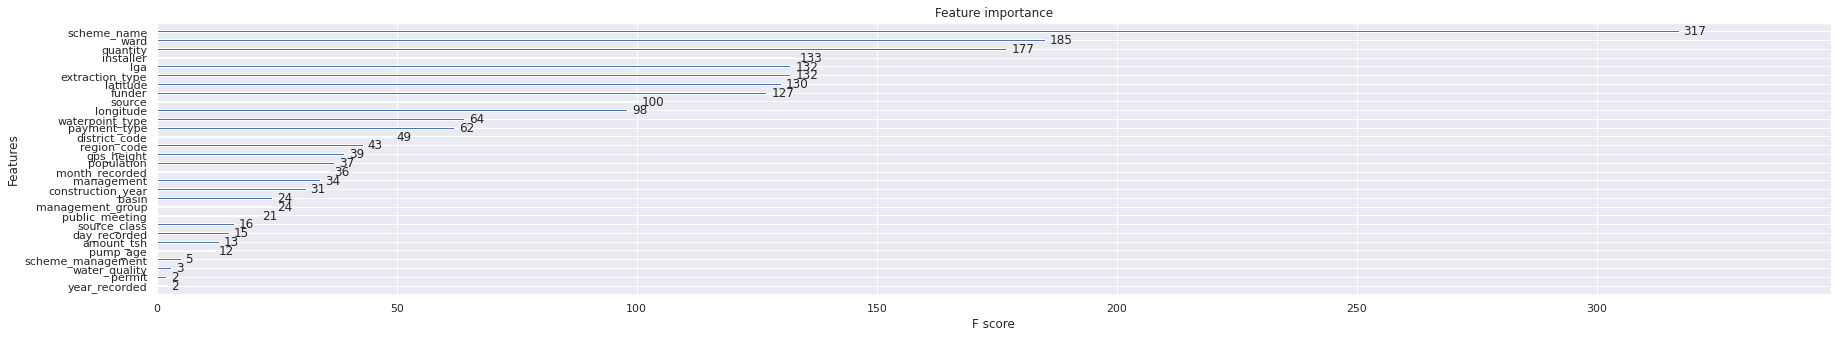

In [ ]:
from xgboost import plot_importance

imp_model = XGBClassifier()
imp_model.fit(features_dfcp, labels_df)


# plot feature importance
plt.figure(figsize=(20,8))
plot_importance(imp_model)
plt.show()

# Training and Evaluation

In [ ]:
print(labels_df.shape)
print(features_dfcp_nom.shape)

(59400, 1)
(59400, 31)


In [ ]:
#split dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_dfcp,
    labels_df,
    test_size=0.25,  #change 0.33 to 0.25
    shuffle=True,
    stratify=labels_df
)

## Catboost classifier

In [ ]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_eval, label=y_eval)

### Hyperparameter Tuning

In [ ]:
cbc =CatBoostClassifier(
    iterations=300,
    random_strength=0.1,
    depth=10,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
)

In [ ]:
#Random search
import random
# Creating the hyperparameter grid
param_dist = { "learning_rate": np.linspace(0.15,0.2,3),
}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='accuracy', cv =5)

#Fit the model
#rscv.fit(features_dfcp,labels_df)

# Print the tuned parameters and score
#print(rscv.best_params_)
#print(rscv.best_score_)

In [ ]:
0.18861
0.17222

0.17222

In [ ]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.15,
    random_strength=0.1,
    depth=10,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
)

In [ ]:
model.fit(train_pool,plot=True,eval_set=test_pool,early_stopping_rounds=10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7624018	test: 0.7627609	best: 0.7627609 (0)	total: 205ms	remaining: 3m 24s
1:	learn: 0.7677441	test: 0.7684175	best: 0.7684175 (1)	total: 388ms	remaining: 3m 13s
2:	learn: 0.7684400	test: 0.7717172	best: 0.7717172 (2)	total: 583ms	remaining: 3m 13s
3:	learn: 0.7698541	test: 0.7726599	best: 0.7726599 (3)	total: 763ms	remaining: 3m 9s
4:	learn: 0.7726824	test: 0.7754209	best: 0.7754209 (4)	total: 952ms	remaining: 3m 9s
5:	learn: 0.7744108	test: 0.7771717	best: 0.7771717 (5)	total: 1.14s	remaining: 3m 8s
6:	learn: 0.7766554	test: 0.7780471	best: 0.7780471 (6)	total: 1.32s	remaining: 3m 7s
7:	learn: 0.7758474	test: 0.7787879	best: 0.7787879 (7)	total: 1.51s	remaining: 3m 7s
8:	learn: 0.7780920	test: 0.7800673	best: 0.7800673 (8)	total: 1.7s	remaining: 3m 7s
9:	learn: 0.7795735	test: 0.7797980	best: 0.7800673 (8)	total: 1.88s	remaining: 3m 6s
10:	learn: 0.7805387	test: 0.7814815	best: 0.7814815 (10)	total: 2.07s	remaining: 3m 6s
11:	learn: 0.7806510	test: 0.7825589	best: 0.78255

### Feature importance for catboost classifier

In [ ]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': features_dfcp_nom.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
23,11.883781,quantity
10,8.885504,ward
14,7.194515,scheme_name
9,5.537896,lga
17,5.472278,extraction_type
1,5.274620,funder
3,5.211832,installer
26,4.665218,waterpoint_type
5,4.232807,latitude
4,4.221293,longitude


**mode imputation, label encoding**

bestTest = 0.7858585859 

bestIteration = 139

**mode imputer, target encoding**

bestTest = 0.8011447811

bestIteration = 95

**mode imputer, target encoding, merge scheme_management and management**

bestTest = 0.804040404

bestIteration = 140

**lr = 0.17222**


bestTest = 0.8117845118

bestIteration = 100

**lr == 0.18561**

bestTest = 0.816969697

bestIteration = 130

**new 0 imputations and NaN imputations**

bestTest = 0.8094276094

bestIteration = 73

**lr=0.15**

bestTest = 0.8153535354

bestIteration = 110


**lr-0.15 nomalized 25% split**

bestTest = 0.8173737374

bestIteration = 118

Train on full dataset

In [ ]:
model.fit(features_dfcp_nom, labels_dfcp)

0:	learn: 0.7640404	total: 238ms	remaining: 3m 57s
1:	learn: 0.7700168	total: 468ms	remaining: 3m 53s
2:	learn: 0.7723906	total: 709ms	remaining: 3m 55s
3:	learn: 0.7727104	total: 941ms	remaining: 3m 54s
4:	learn: 0.7753872	total: 1.18s	remaining: 3m 55s
5:	learn: 0.7759933	total: 1.42s	remaining: 3m 55s
6:	learn: 0.7779966	total: 1.66s	remaining: 3m 55s
7:	learn: 0.7789057	total: 1.9s	remaining: 3m 55s
8:	learn: 0.7797811	total: 2.13s	remaining: 3m 55s
9:	learn: 0.7795623	total: 2.36s	remaining: 3m 54s
10:	learn: 0.7815657	total: 2.6s	remaining: 3m 53s
11:	learn: 0.7822727	total: 2.84s	remaining: 3m 54s
12:	learn: 0.7828283	total: 3.08s	remaining: 3m 53s
13:	learn: 0.7847475	total: 3.33s	remaining: 3m 54s
14:	learn: 0.7848990	total: 3.58s	remaining: 3m 54s
15:	learn: 0.7848653	total: 3.82s	remaining: 3m 54s
16:	learn: 0.7873737	total: 4.07s	remaining: 3m 55s
17:	learn: 0.7885690	total: 4.31s	remaining: 3m 55s
18:	learn: 0.7899158	total: 4.55s	remaining: 3m 54s
19:	learn: 0.7906229	tot

## Generating the predictions for the test test

In [ ]:
test_probas = model.predict(test_dfcp_nom)
test_probas

array([['functional'],
       ['functional'],
       ['functional'],
       ...,
       ['functional'],
       ['functional'],
       ['non functional']], dtype=object)

In [ ]:
submission_df = pd.read_csv(DATA_PATH / "SubmissionFormat.csv", 
                            index_col="id")

In [ ]:
test_prob_df=pd.DataFrame(test_probas, columns=submission_df.columns, index = submission_df.index)

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_dfcp_nom.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["status_group"] = test_prob_df['status_group']

submission_df.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [ ]:
submission_df.to_csv('submission_16.csv', index=True)

In [ ]:
!head submission_16.csv

head: cannot open 'submission_16.csv' for reading: No such file or directory


In [ ]:
!mv submission_16.csv '/content/drive/My Drive/ml_project/dataset'

# XGB Classifier

In [ ]:
xgbmodel = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    reg_alpha=0.01,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    seed=27)

xgbmodel.fit(features_dfcp_nom, labels_df)

X_test = test_dfcp_nom

predictions = xgbmodel.predict(X_test)

output = pd.DataFrame({'id': X_test.index, 'status_group': predictions})
output.to_csv('/content/drive/My Drive/ml_project/dataset/submission-2.csv', index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
output.head()